<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка и подготовка данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Предобработка-и-исследовательский-анализ-данных" data-toc-modified-id="Предобработка и исследовательский анализ данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка и исследовательский анализ данных</a></span></li><li><span><a href="#Бизнес-метрика" data-toc-modified-id="Бизнес-метрика-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Бизнес-метрика</a></span></li><li><span><a href="#Разработка-модели-ML" data-toc-modified-id="Разработка модели ML-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Разработка модели ML</a></span></li><li><span><a href="#Портрет-«ненадёжного»-клиента" data-toc-modified-id="Портрет-«ненадёжного»-клиента-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Портрет «ненадёжного» клиента</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий вывод"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».  
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.  
Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.  

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.  
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.  

Стоимость номеров отеля:  
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.  

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.  
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.  
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.  

### Загрузка и подготовка данных

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from catboost import CatBoostClassifier, Pool
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, ConfusionMatrixDisplay

In [2]:
# фильтр предупреждений
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# загрузим файлы с данными
try:
    df_train = pd.read_csv('/datasets/hotel_train.csv')
    df_test = pd.read_csv('/datasets/hotel_test.csv')
except:
    df_train = pd.read_csv('/Users/alex/Desktop/Яндекс_Практикум/Проекты/Сборный_проект_2/hotel_train.csv')
    df_test = pd.read_csv('/Users/alex/Desktop/Яндекс_Практикум/Проекты/Сборный_проект_2/hotel_test.csv')

df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [4]:
# посмотрим на данные в таблицах
display(df_train.sample(3))
df_test.sample(3)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
58103,76761,0,7.0,2016,August,36,31,0,1,2.0,...,0,0,0,A,0,0,Transient,0,3,1
44788,63227,0,3.0,2015,December,52,21,1,1,2.0,...,0,0,0,B,0,0,Transient-Party,0,1,2
4979,5036,1,91.0,2016,September,38,11,2,2,2.0,...,0,0,0,A,0,0,Transient,0,0,4


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2114,8221,1,246.0,2017,August,35,29,2,5,2.0,...,0,0,0,A,1,0,Transient,0,0,7
27451,92943,0,34.0,2017,June,23,5,1,2,1.0,...,0,0,0,A,1,0,Transient,0,0,3
3525,20446,0,0.0,2017,February,6,10,0,1,2.0,...,1,0,0,A,0,0,Transient-Party,0,1,1


**Описание данных** 

В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:
* `id` — номер записи;
* `is_canceled` — отмена заказа;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `adults` — количество взрослых постояльцев;
* `children` — количество детей от 3 до 14 лет;
* `babies` — количество младенцев;
* `meal` — опции заказа:
** `SC` — нет дополнительных опций;
** `BB` — включён завтрак;
** `HB` — включён завтрак и обед;
** `FB` — включён завтрак, обед и ужин.
* `country` — гражданство постояльца;
* `distribution_channel` — канал дистрибуции заказа;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `reserved_room_type` — тип забронированной комнаты;
* `booking_changes` — количество изменений параметров заказа;
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `customer_type` — тип заказчика:
** `Contract` — договор с юридическим лицом;
** `Group` — групповой заезд;
** `Transient` — не связано с договором или групповым заездом;
** `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа `Transient`.
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `total_of_special_requests` — количество специальных отметок;
* `total_nights` — общее количество ночей.

Целевая переменная `in_canceled` принимает два значения:
* `1` – бронь была отменена,
* `0` – не отменена.  

Соответственно, будем решать задачу классификации.

### Предобработка и исследовательский анализ данных

Проверим загруженные данные на пропуски, выбросы.

In [5]:
# посмотрим на все данные в обеих таблицах
df_train_test = pd.concat([df_train, df_test]).reset_index(drop=True)
df_train_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97636,97899,0,164.0,2017,August,35,31,2,4,2.0,...,0,0,0,A,0,0,Transient,0,0,6
97637,97900,0,21.0,2017,August,35,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,2,7
97638,97901,0,23.0,2017,August,35,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7
97639,97902,0,34.0,2017,August,35,31,2,5,2.0,...,0,0,0,D,0,0,Transient,0,4,7


In [6]:
# удалим столбец с идентификатором клиента
df_train_test_n = df_train_test.drop('id', axis=1)

In [7]:
# числовые переменные преобразуем в int, категориальные в строковый формат
df_train_test['id'] = df_train_test['id'].astype('str')
df_train_test['arrival_date_year'] = df_train_test['arrival_date_year'].astype('str')

df_train_test['arrival_date_week_number'] = df_train_test['arrival_date_week_number'].astype('str')
df_train_test['arrival_date_day_of_month'] = df_train_test['arrival_date_day_of_month'].astype('str')


df_train_test['is_repeated_guest'] = df_train_test['is_repeated_guest'].astype('str')

df_train_test['required_car_parking_spaces'] = df_train_test['required_car_parking_spaces'].astype('str')

df_train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97641 entries, 0 to 97640
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              97641 non-null  object 
 1   is_canceled                     97641 non-null  int64  
 2   lead_time                       97641 non-null  float64
 3   arrival_date_year               97641 non-null  object 
 4   arrival_date_month              97641 non-null  object 
 5   arrival_date_week_number        97641 non-null  object 
 6   arrival_date_day_of_month       97641 non-null  object 
 7   stays_in_weekend_nights         97641 non-null  int64  
 8   stays_in_week_nights            97641 non-null  int64  
 9   adults                          97641 non-null  float64
 10  children                        97641 non-null  float64
 11  babies                          97641 non-null  float64
 12  meal                            

In [8]:
# посмотрим описательные статистики
df_train_test.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,total_of_special_requests,total_nights
count,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000
mean,0.375201,96.752839,0.839361,2.263066,1.843887,0.077836,0.006667,0.089972,0.128860,0.201729,2.314642,0.560902,3.102426
std,0.484177,93.045823,0.853682,1.362798,0.483393,0.337358,0.091790,0.797737,1.530961,0.609830,15.224212,0.783654,1.739882
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,19.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,68.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,152.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,4.000000,6.000000,4.000000,3.000000,10.000000,26.000000,72.000000,18.000000,259.000000,5.000000,10.000000


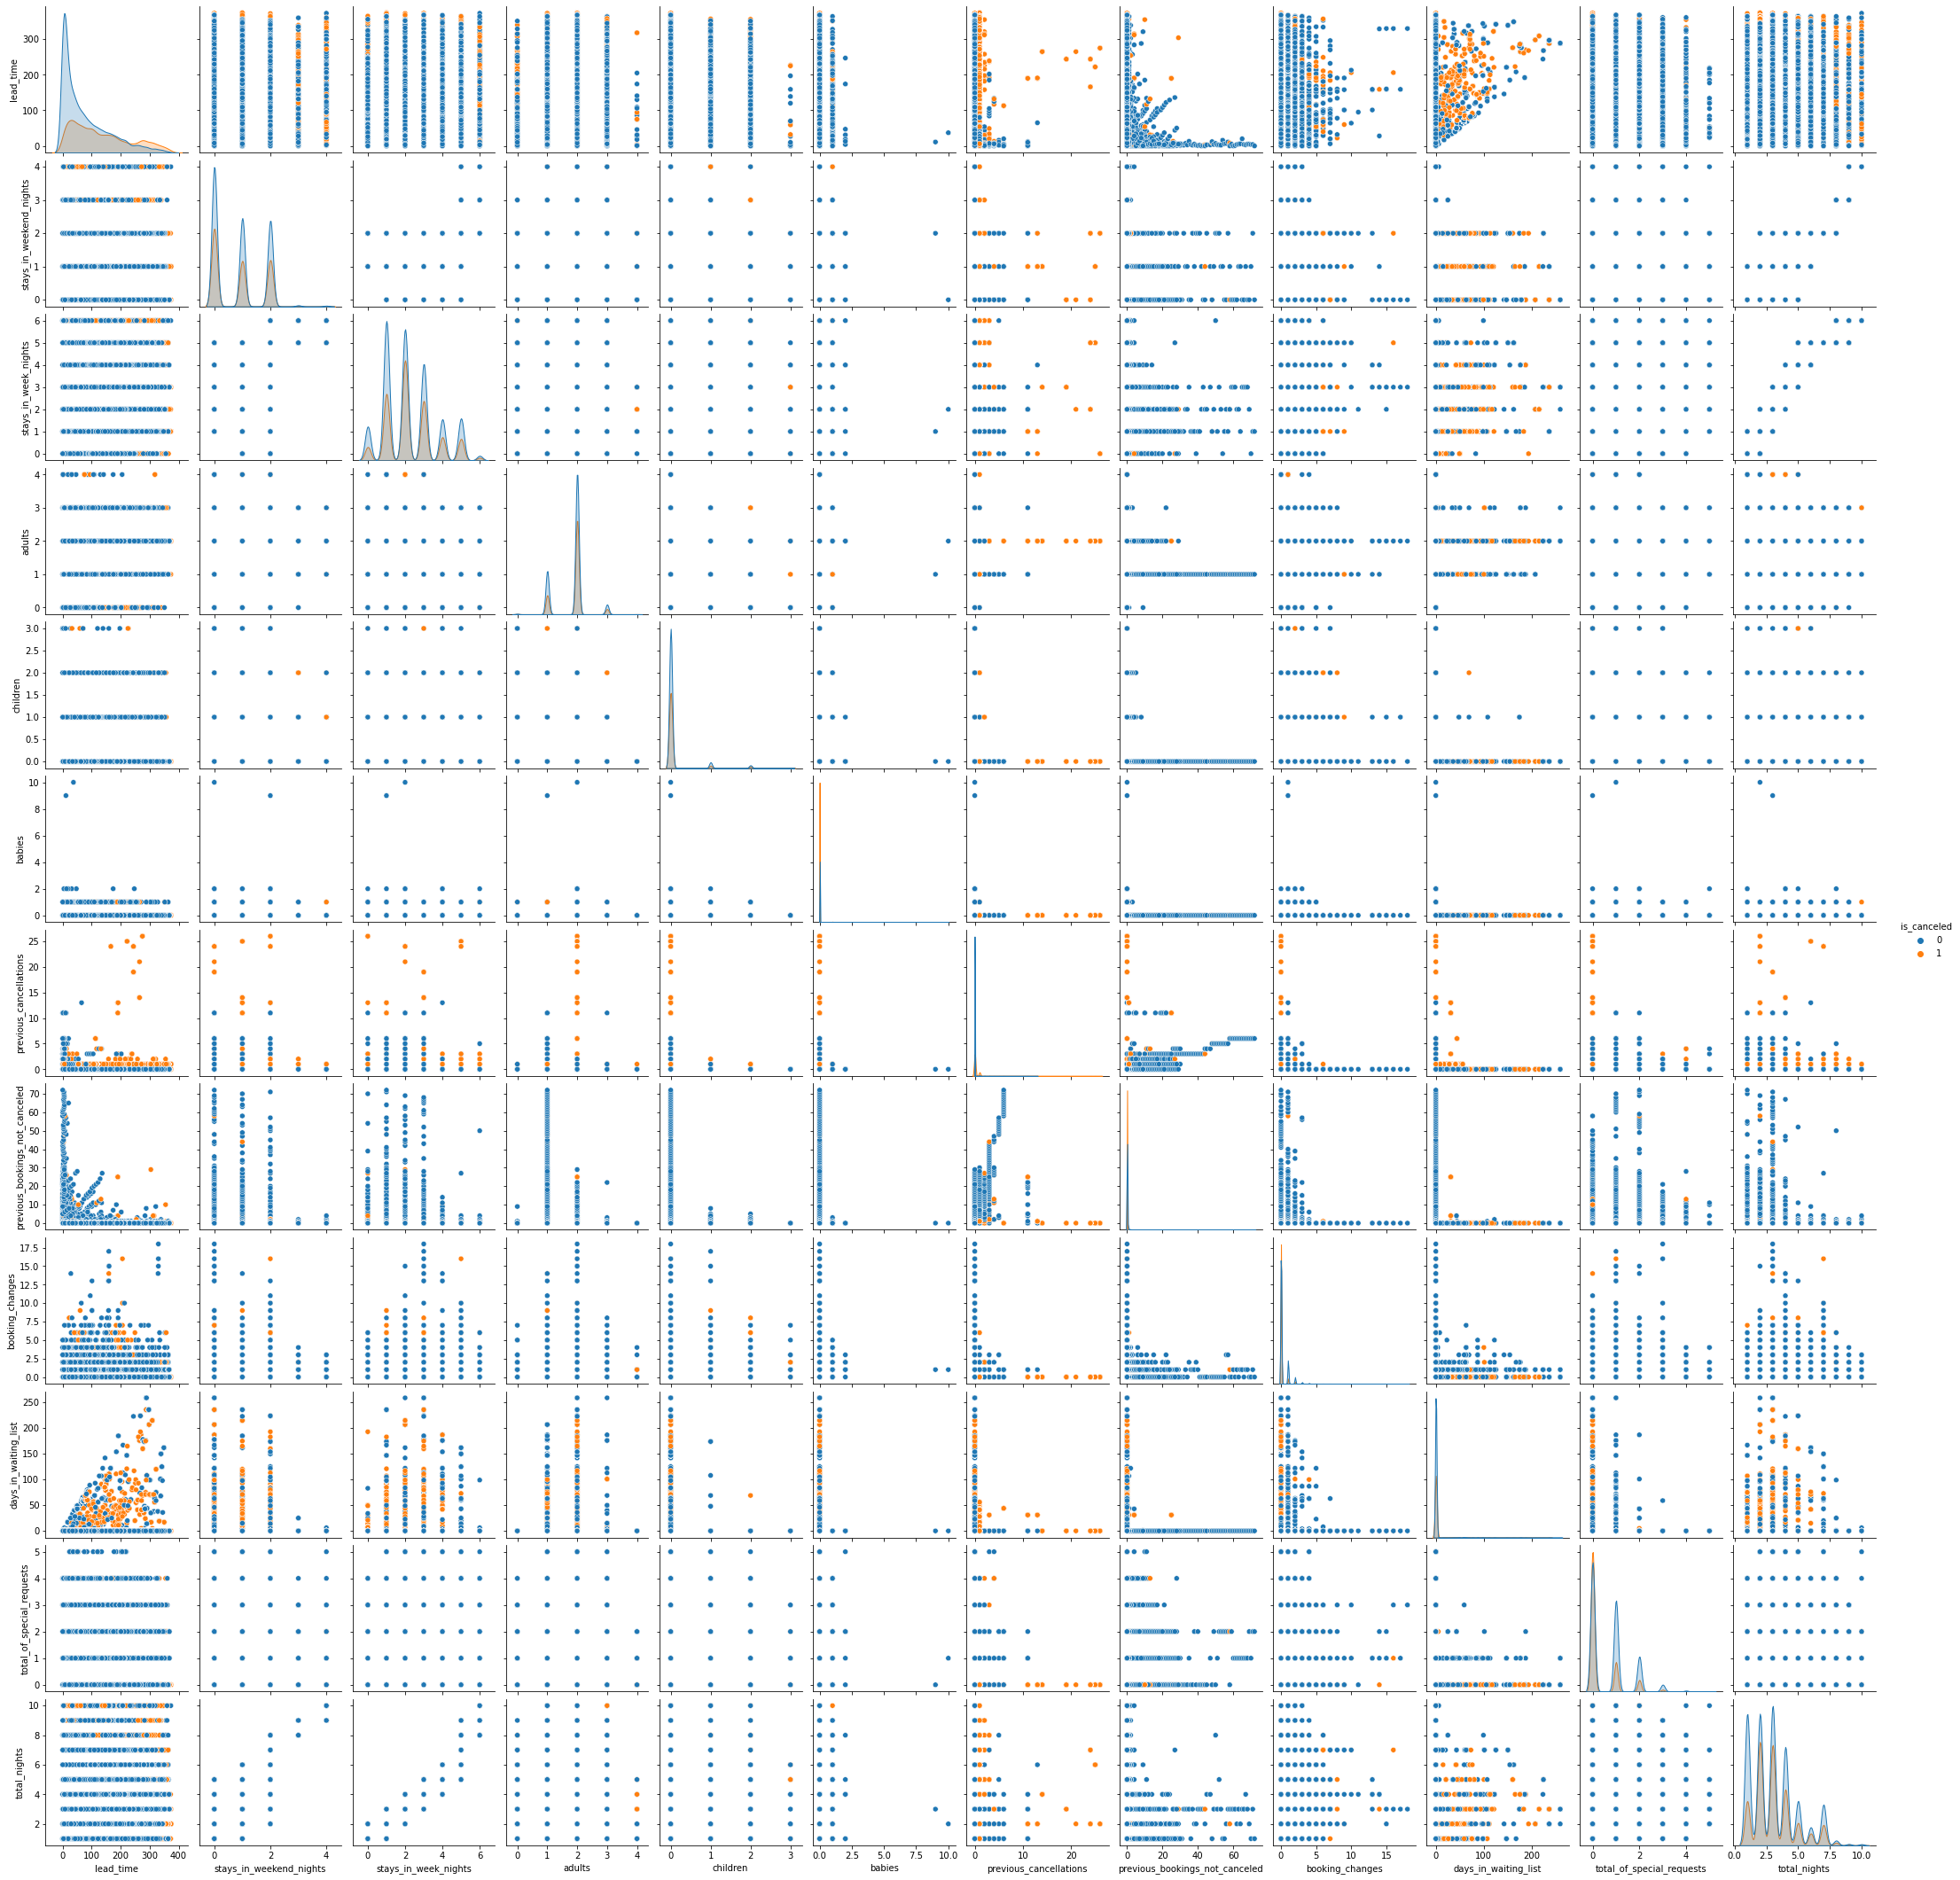

In [9]:
# посмотрим на числовые признаки и их взаимосвязь с отменой бронирования
sns.pairplot(df_train_test, hue='is_canceled')
plt.show()

In [10]:
# уникальные значения в столбце с количеством дней ожидания подтверждения
df_train_test['lead_time'].value_counts()

0.0      4799
1.0      2767
2.0      1648
3.0      1454
4.0      1385
         ... 
361.0       8
347.0       5
354.0       4
362.0       1
366.0       1
Name: lead_time, Length: 372, dtype: int64

In [11]:
# уникальные значения в столбце с количеством взрослых
display(df_train_test['adults'].unique())
df_train_test['adults'].value_counts()

array([1., 2., 3., 4., 0.])

2.0    73217
1.0    19492
3.0     4675
0.0      235
4.0       22
Name: adults, dtype: int64

235 бронирований без взрослых - похоже на выбросы.

In [12]:
# уникальные значения в столбце с количеством детей от 3-х лет
df_train_test['children'].unique()

array([0., 1., 2., 3.])

In [13]:
# уникальные значения в столбце с количеством детей от 3-х лет
df_train_test['babies'].unique()

array([ 0.,  1.,  2., 10.,  9.])

Значения `10` и `9` - похожи на выбросы, заменим их на значение `1`, как более соответствующее реальности.

In [14]:
# уникальные значения в столбце с типом питания
df_train_test['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

Пробелы не несут нужной информации, подлежат удалению.

In [15]:
# уникальные значения в столбце с типом номера
df_train_test['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

Пробелы удалим.

In [16]:
# уникальные значения в столбце с количеством дней ожидания подтверждения
display(df_train_test['days_in_waiting_list'].unique())
df_train_test['days_in_waiting_list'].value_counts()

array([  0,  50,  47,  65, 122,  75, 101, 150, 125,  22, 142,   2,  13,
        44,  38,  48,  33,  77,  21,  80,  59,  40,  58,  89,  53,  49,
        60,  69,  87,  91,  57,  99, 111,  79,  98,  85,  63,  15,   3,
        20,  93,   4,  41,  34, 224,  31,  39,  56, 187, 176,  71,  55,
        96, 236, 259, 207, 215, 160, 120,  30,  32,  27,  62,  24, 108,
       147,   5,  14, 107,  70,   8,  35, 178, 174, 162,  68,  11, 193,
        10,  76,  17,  45,   6,  19,  28,  42,  25,  46,   9,   1,  43,
        72,  12,  61,  81,  74, 167, 100, 121,  83, 113,  18, 185, 109,
       154,  64,  16, 165,   7,  84, 175, 183,  23, 117,  54,  26,  73,
       223, 105,  36])

0      94240
39       186
58       164
44       141
31       127
       ...  
81         1
74         1
109        1
167        1
36         1
Name: days_in_waiting_list, Length: 120, dtype: int64

In [17]:
# уникальные значения в столбце с необходимостью места для автомобиля
display(df_train_test['required_car_parking_spaces'].unique())
df_train_test['required_car_parking_spaces'].value_counts()

array(['0', '1', '2', '3', '8'], dtype=object)

0    92482
1     5138
2       17
3        2
8        2
Name: required_car_parking_spaces, dtype: int64

In [18]:
# уникальные значения в столбце с общим количеством ночей
df_train_test['total_nights'].value_counts()

3     24047
2     23555
1     17587
4     15457
5      6697
7      6137
6      3017
8       757
9       214
10      173
Name: total_nights, dtype: int64

* Клиенты могут бронировать отель сильно заранее, более чем за год, но большинство клиентов делают бронь за 2-3 месяца;
* Данные за три года (2015-2017);
* Количество взрослых максимум четверо в одной брони, есть нулевые значения (похоже на выбросы);
* Количество детей до 3-х лет не более трёх;
* Количество младенцев максимум десять (похоже на выбросы);
* Максимальное количество подтвержденых заказов в несколько раз превышает максимальное количество подтверждённых заказов - у сети отелей много постоянных клиентов;
* Количество дней ожидания подтверждения заказа может быть более восьми месяцев, хотя и более 97% клиентов ждут менее одного дня;
* Количество необходимых парковочных мест для автомобилей может быть максимум восемь, хотя и более 94% клиентов не запрашивают парковочное место;
* Более 82% клиентов бронируют номер на 1-4 ночи.

На основе исследованных суммарных данных, отредактируем тренировочные и тестовые наборы.  
Столбец с идентификатором не несёт необходимой информации. Столбцы с номером недели, количеством ночей в будни и выходные, количеством подтверждённых заказов несут избыточную информацию, которая есть в других столбцах. Столбец с годом заезда - не несёт полезной информации.

In [19]:
# удалим столбцы с id, годом, номером недели, количеством ночей в будни и выходные, количество подтверждённых заказов
df_train = df_train.drop(['id', 'arrival_date_year', 'arrival_date_week_number', 'stays_in_week_nights',
                          'stays_in_weekend_nights', 'previous_bookings_not_canceled'], axis=1)
df_test = df_test.drop(['id', 'arrival_date_year', 'arrival_date_week_number', 'stays_in_week_nights',
                        'stays_in_weekend_nights', 'previous_bookings_not_canceled'], axis=1)

display(df_train.sample())
df_test.sample()

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
1094,0,85.0,September,19,2.0,0.0,0.0,HB,GBR,TA/TO,0,0,D,0,0,Transient,0,0,7


,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23790,0,74.0,April,9,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,A,0,0,Transient,0,1,3


In [20]:
# уберём пробелы в столбцах с опциями заказа и типом комнаты
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()
df_train['meal'] = df_train['meal'].str.strip()
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()
df_test['meal'] = df_test['meal'].str.strip()
display(df_train['reserved_room_type'].unique())
df_test['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

In [21]:
# заменим выбросы на более реальные значения
df_train['babies'] = df_train['babies'].replace(10, 1)
df_train['babies'] = df_train['babies'].replace(9, 1)
df_test['babies'] = df_test['babies'].replace(10, 1)
df_test['babies'] = df_test['babies'].replace(9, 1)
df_train['adults'] = df_train['adults'].replace(0, 2)
df_test['adults'] = df_test['adults'].replace(0, 2)

In [22]:
# проверим дубликаты
print(f"Количество дубликатов: {df_train.duplicated().sum()}")
print(f"Количество дубликатов: {df_test.duplicated().sum()}")

Количество дубликатов: 21446
Количество дубликатов: 7732


In [23]:
# удалим явные дубликаты и сформируем новые индексы
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)
print(f"Количество дубликатов: {df_train.duplicated().sum()}")
print(f"Количество дубликатов: {df_test.duplicated().sum()}")

Количество дубликатов: 0
Количество дубликатов: 0


In [24]:
# числовые переменные преобразуем в int, категориальные в строковый формат
df_train['lead_time'] = df_train['lead_time'].astype('int')
df_train['adults'] = df_train['adults'].astype('int')
df_train['children'] = df_train['children'].astype('int')
df_train['babies'] = df_train['babies'].astype('int')

df_train['arrival_date_day_of_month'] = df_train['arrival_date_day_of_month'].astype('str')
df_train['is_repeated_guest'] = df_train['is_repeated_guest'].astype('str')

df_test['lead_time'] = df_train['lead_time'].astype('int')
df_test['adults'] = df_train['adults'].astype('int')
df_test['children'] = df_train['children'].astype('int')
df_test['babies'] = df_train['babies'].astype('int')

df_test['arrival_date_day_of_month'] = df_train['arrival_date_day_of_month'].astype('str')
df_test['is_repeated_guest'] = df_train['is_repeated_guest'].astype('str')

display(df_train.info())
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43783 entries, 0 to 43782
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   is_canceled                  43783 non-null  int64 
 1   lead_time                    43783 non-null  int64 
 2   arrival_date_month           43783 non-null  object
 3   arrival_date_day_of_month    43783 non-null  object
 4   adults                       43783 non-null  int64 
 5   children                     43783 non-null  int64 
 6   babies                       43783 non-null  int64 
 7   meal                         43783 non-null  object
 8   country                      43783 non-null  object
 9   distribution_channel         43783 non-null  object
 10  is_repeated_guest            43783 non-null  object
 11  previous_cancellations       43783 non-null  int64 
 12  reserved_room_type           43783 non-null  object
 13  booking_changes              43

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24680 entries, 0 to 24679
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   is_canceled                  24680 non-null  int64 
 1   lead_time                    24680 non-null  int64 
 2   arrival_date_month           24680 non-null  object
 3   arrival_date_day_of_month    24680 non-null  object
 4   adults                       24680 non-null  int64 
 5   children                     24680 non-null  int64 
 6   babies                       24680 non-null  int64 
 7   meal                         24680 non-null  object
 8   country                      24680 non-null  object
 9   distribution_channel         24680 non-null  object
 10  is_repeated_guest            24680 non-null  object
 11  previous_cancellations       24680 non-null  int64 
 12  reserved_room_type           24680 non-null  object
 13  booking_changes              24

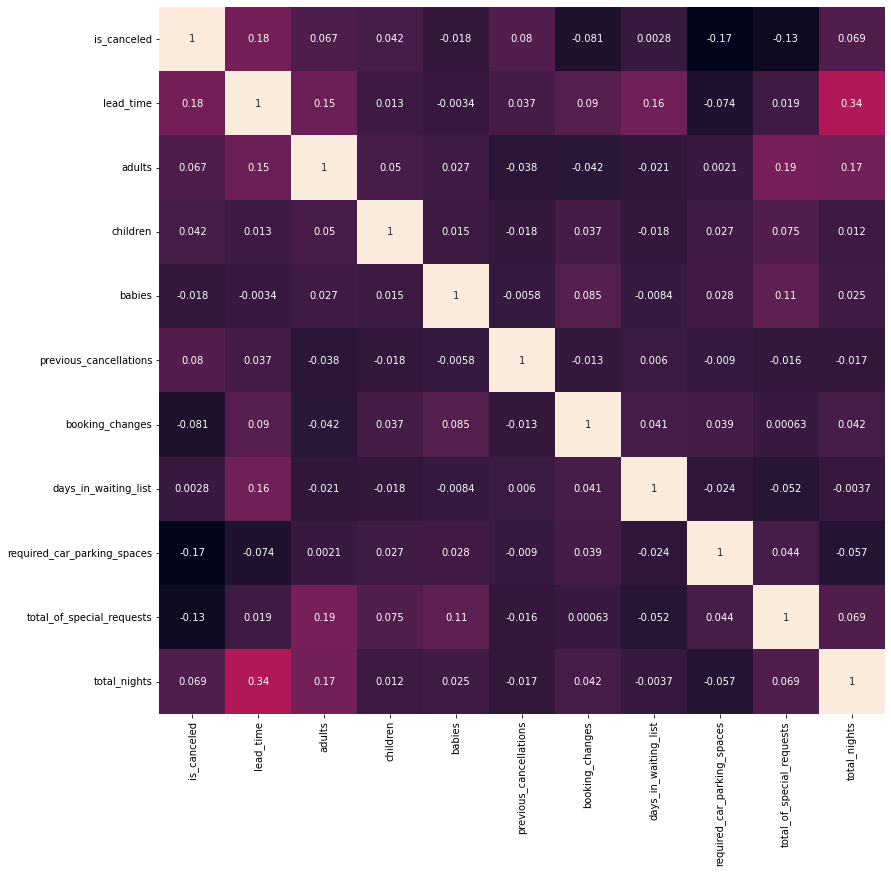

In [25]:
# корреляционная матрица
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(df_train.corr(), annot=True, ax=ax, cbar=False)
plt.show()

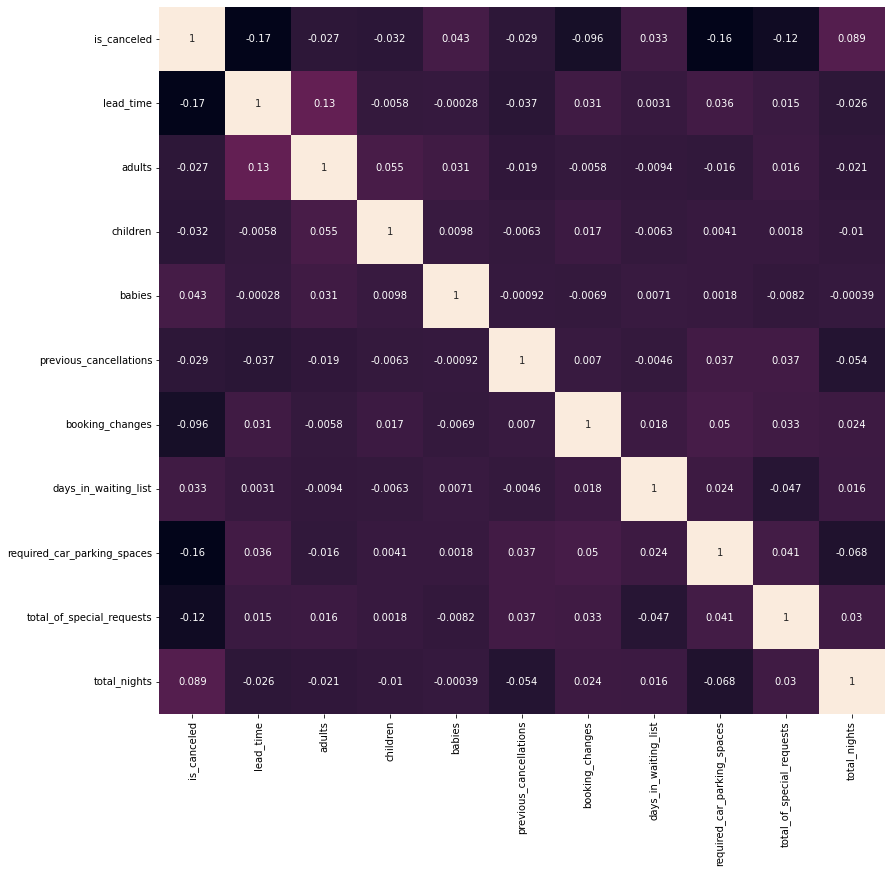

In [26]:
# корреляционная матрица
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(df_test.corr(), annot=True, ax=ax, cbar=False)
plt.show()

Между целевой переменной `is_canceled` и остальными признаками есть прямые и отрицательные зависимости.  
Наиболее заметная взаимосвязь между `is_canceled` и факторами: 
* `lead_time`: `0.33/-0.3`,
* `total_of_special_requests`: `-0.26/-0.22`,
* `required_car_parking_spaces`: `-0.19/-0.17`,
* `previous_cancellations`: `0.15/-0.033`,
* `booking_changes`: `-0.14/-014`. 

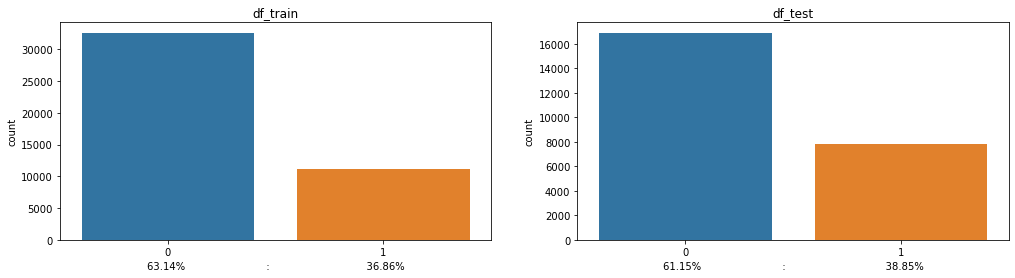

In [27]:
# распределение признака целевой переменной
fig,axes=plt.subplots(1,2)
fig.set_size_inches(17, 4)
ax = sns.countplot(df_train['is_canceled'], ax = axes[0])
ax1 = sns.countplot(df_test['is_canceled'], ax = axes[1])
ax.set(title = 'df_train', xlabel = ('63.14%                          :                               36.86%'))
ax1.set(title = 'df_test', xlabel = ('61.15%                          :                                38.85%'))
plt.show()

Данные не сбалансированны по целевой переменной.

Преобразуем категориальные признаки как целочисленный массив с помощью OrdinalEncoder.

In [28]:
# закодируем категориальные признаки как целочисленный массив с помощью OrdinalEncoder
enc = OrdinalEncoder()
df_train_oe = df_train.copy(deep=True)
df_train_oe[['arrival_date_month', 'arrival_date_day_of_month', 'meal', 'country', 'distribution_channel',
             'is_repeated_guest', 'previous_cancellations', 'reserved_room_type', 'customer_type',
             'required_car_parking_spaces']] = enc.fit_transform(df_train_oe[['arrival_date_month',
                                                                           'arrival_date_day_of_month', 'meal',
                                                                           'country', 'distribution_channel',
                                                                           'is_repeated_guest',
                                                                           'previous_cancellations',
                                                                           'reserved_room_type', 'customer_type',
                                                                           'required_car_parking_spaces']])

df_test_oe = df_test.copy(deep=True)
df_test_oe[['arrival_date_month', 'arrival_date_day_of_month', 'meal', 'country', 'distribution_channel',
             'is_repeated_guest', 'previous_cancellations', 'reserved_room_type', 'customer_type',
             'required_car_parking_spaces']] = enc.fit_transform(df_test_oe[['arrival_date_month',
                                                                           'arrival_date_day_of_month', 'meal',
                                                                           'country', 'distribution_channel',
                                                                           'is_repeated_guest',
                                                                           'previous_cancellations',
                                                                           'reserved_room_type', 'customer_type',
                                                                           'required_car_parking_spaces']])

target_train = df_train_oe['is_canceled']
features_train = df_train_oe.drop(['is_canceled'], axis = 1)

target_test = df_test_oe['is_canceled']
features_test = df_test_oe.drop(['is_canceled'], axis = 1)
display(features_train.sample())
features_test.sample()

,lead_time,arrival_date_month,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23767,70,2.0,29.0,2,0,0,3.0,106.0,3.0,0.0,0.0,0.0,0,0,2.0,0.0,2,1


,lead_time,arrival_date_month,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22373,7,4.0,25.0,1,0,0,0.0,34.0,3.0,0.0,0.0,0.0,0,0,2.0,0.0,0,3


### Бизнес-метрика

Рассчитаем и оценим прибыль отеля без внедрения депозитов.  
Прибыль — разница между стоимостью номера за все ночи и затраты на обслуживание.

In [29]:
# вспомогательная функция для добавления коэффициента в зависимости от сезона
def seasons(row):
    summer = ['June', 'July', 'August']
    spring_autumn = ['September', 'October', 'November', 'March', 'April', 'May']
    for i in range(len(summer)):
        if row['arrival_date_month'] == summer[i]:
            return 1.4
    for i in range(len(spring_autumn)):
        if row['arrival_date_month'] == spring_autumn[i]:
            return 1.2
        else:
            return 1 
df_train['seasonal_factor'] = df_train.apply(seasons, axis=1)
df_test['seasonal_factor'] = df_test.apply(seasons, axis=1)
display(df_train.sample())
df_test.sample()

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,seasonal_factor
24077,1,102,December,26,2,2,0,BB,ESP,TA/TO,0,0,B,0,0,Transient-Party,0,0,4,1.0


,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,seasonal_factor
19713,0,290,May,17,2,0,0,HB,DEU,TA/TO,0,0,A,0,0,Transient-Party,0,0,2,1.0


In [30]:
# функция рассчёта прибыли по каждому клиенту
def profit(row):
    r_t = row['reserved_room_type']
    s_f = row['seasonal_factor']
    t_n = row['total_nights']
    room_k = {'A': [1000, 400],
              'B': [800, 350],
              'C': [600, 350], 'D': [550, 150], 'E': [500, 150], 'F': [450, 150], 'G': [350, 150]}
    for i in room_k.keys():
        if row['is_canceled']>0:
            if 'predictions' in list(row.index) and row['predictions'] > 0:
                if r_t == i:
                    return ((-1*(room_k[i][0]*s_f + room_k[i][1]*s_f))+((room_k[i][0] + room_k[i][1])*s_f*0.8))
            else:
                if r_t == i:
                    return ((-1*(room_k[i][0]*s_f + room_k[i][1]*s_f)))  
        else:
            return t_n*(room_k[i][0]*s_f) - math.ceil(t_n/2)*(room_k[i][1]*s_f)

df_train['income'] = df_train.apply(profit, axis=1)
display(df_train.sample())
display(df_train['income'].sum())
df_test['income'] = df_test.apply(profit, axis=1)
display(df_test.sample())
df_test['income'].sum()

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,...,previous_cancellations,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,seasonal_factor,income
32787,0,28,May,20,2,0,0,BB,DEU,TA/TO,...,0,D,0,0,Transient,0,2,1,1.0,600.0


73610780.0

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,adults,children,babies,meal,country,distribution_channel,...,previous_cancellations,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,seasonal_factor,income
475,1,16,April,31,1,0,0,BB,BEL,TA/TO,...,0,A,2,0,Transient-Party,0,1,7,1.0,-1400.0


36701700.0

Прибыль за 2016-2017гг.: `110312480` .  
Прибыль за тестовый период: `36701700` .


### Разработка модели ML

#### Обучение и выбор моделей

* Выберем метрику для обучения; 
* Обучим разные модели и оценим их качество кросс-валидацией;  
* Выберем лучшую модель и проверим её на тестовой выборке; 
* Оценим прибыль, которую принесёт выбранная модель за год.

C точки зрения бизнеса, основная цель нашей модели — максимизировать прибыль, путем минимизации убытков. В контексте модели это значит минимизировать количество ложноотрицательных ответов — то есть те случаи, когда модель решит, что этот клиент приедет, а он все равно отменит бронь. Поэтому, основной метрикой может быть `recall`. А так же, метрикой может являться, непосредственно, сама прибыль бизнеса, или бизнес-метрика.

In [31]:
# используем бизнес-метрику в качестве метрики для оценки моделей, создадим свой scorer с помощью make_scorer
# подберём наилучшие гипермараметры с помощью GridSearchCV для CatBoostClassifier
def profit_scorer(y, y_pred, df):
    y_pred_series = pd.Series(y_pred, index=y.index, name='predictions')
    df = df[df.index.isin(y.index)].join(y_pred_series)
    df['profit'] = df.apply(profit, axis=1)
    return df['profit'].sum()

random_state = 42
cv =10
catboost = CatBoostClassifier(random_seed=random_state, silent=True, auto_class_weights='Balanced')

#catboost_params = {'depth': [2, 4, 5, 6, 7, 8, 9, 10],
#                   'learning_rate': [.01, .1, .5, .7, .9, 2, 10, 20, 30],
#                   'iterations': [10, 50, 100, 500, 1000],
#                   'l2_leaf_reg': [2, 3, 5, 9, 15, 20, 27, 31]}

#grid_search_catboost = GridSearchCV(catboost, catboost_params, verbose=True, cv=cv, n_jobs=-1,
#                                    scoring=make_scorer(profit_scorer, df=df_train))

#grid_search_catboost.fit(features_train, target_train)
#grid_search_catboost.best_score_
#grid_search_catboost.best_params_

Наилучшие гиперпараметры модели `CatBoostClassifier` :  
`{'depth': 2,  
'iterations': 5,  
'l2_leaf_reg': 2,  
'learning_rate': 0.01}` .

In [32]:
# подберём наилучшие гипермараметры с помощью GridSearchCV для DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state = random_state, class_weight='balanced')

#tree_params = {'max_features': ['auto', 'sqrt', 'log2'],
#             'ccp_alpha': [0.1, .01, .001, .0001, .00001, .000001, .0000001, .00000001],
#             'max_depth' : [5, 6, 7, 8, 9, 40, 50, 60, 100, 300],
#             'criterion' :['gini', 'entropy']}

#dtc = GridSearchCV(decision_tree, tree_params, verbose=True, cv=cv, n_jobs=-1,
#                  scoring=make_scorer(profit_scorer, df=df_train))
#dtc.fit(features_train, target_train)
#dtc.best_score_
#dtc.best_params_

Наилучшие гиперпараметры модели `DecisionTreeClassifier` :  
`{'ccp_alpha': 0.1,  
'criterion': 'gini',  
'max_depth': 5,  
'max_features': 'auto'}` .

In [33]:
# подберём наилучшие гипермараметры с помощью GridSearchCV для RandomForestClassifier
random_forest = RandomForestClassifier(random_state = random_state, class_weight='balanced')

#for_params = {'n_estimators': [50, 200, 500],
#              'max_features': ['auto', 'sqrt', 'log2'],
#              'max_depth': [5, 6, 7, 8, 9, 40, 50, 60, 100, 300],
#              'criterion': ['gini', 'entropy']}

#rfc = GridSearchCV(random_forest, for_params, verbose=True, cv=cv, n_jobs=-1,
#                  scoring=make_scorer(profit_scorer, df=df_train))
#rfc.fit(features_train, target_train)
#rfc.best_score_
#rfc.best_params_

Наилучшие гиперпараметры модели `RandomForestClassifier` :  
`{'criterion': 'entropy',  
'max_depth': 7,  
'max_features': 'auto', 
'n_estimators': 3}` .

In [34]:
# функция обучения разных моделей и оценка их кросс-валидацией
def modeling (features_modeling, target_modeling, df):
    
    results = []
    models = [DecisionTreeClassifier(random_state = random_state, ccp_alpha=0.1, criterion='gini', max_depth=5,
                                     max_features='auto', class_weight='balanced'),
              RandomForestClassifier(random_state=random_state, criterion='entropy', max_depth=7,
                                     max_features='auto', n_estimators=3, class_weight='balanced'),
              CatBoostClassifier(random_state=random_state, silent=True, depth=2, learning_rate=0.01,
                                 iterations=5, l2_leaf_reg=2, early_stopping_rounds=10, auto_class_weights='Balanced')]
    
    
    scorin = {'prof': make_scorer(profit_scorer, df=df),
              'recall': make_scorer(recall_score),
              'accuracy': make_scorer(accuracy_score),
              'precision' : make_scorer(precision_score),
              'f1_score': make_scorer(f1_score),
              'roc_auc': make_scorer(roc_auc_score)} 
    
    for model in models:
        cross_val_scorer = cross_validate(model,
                                          features_modeling,
                                          target_modeling, cv=cv, scoring=scorin)
        results.append({'Модель': model.__class__.__name__,
                        'Прибыль': cross_val_scorer['test_prof'].mean(),
                        'Recall': cross_val_scorer['test_recall'].mean(),
                        'Accuracy': cross_val_scorer['test_accuracy'].mean(),
                        'Precision': cross_val_scorer['test_precision'].mean(),
                        'F1-мера': cross_val_scorer['test_f1_score'].mean(),
                        'AUC-ROC': cross_val_scorer['test_roc_auc'].mean()})
    return pd.DataFrame(results)
modeling(features_train, target_train, df_train)

,Модель,Прибыль,Recall,Accuracy,Precision,F1-мера,AUC-ROC
0,DecisionTreeClassifier,8058856.4,0.600000,0.451010,0.152792,0.243561,0.50000
1,RandomForestClassifier,8191022.0,0.690932,0.675463,0.418695,0.519978,0.68056
2,CatBoostClassifier,8405118.0,0.876459,0.517570,0.336514,0.484450,0.63573


Лучшие результаты показала модель: `CatBoostClassifier` .

In [41]:
# проверим модель на тестовой выборке
results = []
catboost_b = CatBoostClassifier(random_state=random_state, silent=True, depth=2, learning_rate=0.01,
                                iterations=5, l2_leaf_reg=2, auto_class_weights='Balanced') 
model = catboost_b.fit(features_train, target_train, early_stopping_rounds=3)
#predictions_valid = catboost_b.predict(features_test)
#prof = profit_scorer(target_test, predictions_valid, df_test)
#recall =  recall_score(target_test, predictions_valid)
#results.append({'Модель': model.__class__.__name__,
#                'Прибыль': prof,
#                'Recall': recall})
#pd.DataFrame(results)

In [36]:
# посчитаем прибыль над тестовой выборке, с учётом применения модели и внесения депозитов
df_test['predictions'] = catboost_b.predict(features_test)
df_test['income_p'] = df_test.apply(profit, axis=1)
df_test['income_p'].sum()

41991332.0

In [37]:
# выручка только от внедрения депозитов
deposit_revenue = df_test['income_p'].sum() - df_test['income'].sum()
deposit_revenue

5289632.0

Стоимость внедрения модели: `400` тыс, модель принесла более `5` млн.

### Портрет «ненадёжного» клиента

In [38]:
# важность признаков в модели
pd.DataFrame(catboost_b.get_feature_importance(),
             index=features_test.dtypes.index,
             columns=['Рейтинг признаков']).sort_values(by='Рейтинг признаков',
                                                        ascending = False).style.bar(color=['#d65f5f', '#5fba7d'])

,Рейтинг признаков
lead_time,53.641994
required_car_parking_spaces,46.358006
arrival_date_month,0.000000
total_of_special_requests,0.000000
customer_type,0.000000
days_in_waiting_list,0.000000
booking_changes,0.000000
reserved_room_type,0.000000
previous_cancellations,0.000000
is_repeated_guest,0.000000


На вероятность отмены бронирования больше всего влияет:
* количество дней между датой бронирования и прибытия `lead_time`;
* необходимость места для автомобиля `required_car_parking_spaces`.

In [39]:
# надёжные и ненадёжные клиенты
def my_mean(x): return '{:.2}'.format((x*100).mean())
def pivot_table (data, column, ascendings):
    df_pivot = data.pivot_table(index = column, values='is_canceled',
                                aggfunc=my_mean).astype(float).reset_index().sort_values(by=('is_canceled'
                                                                                              ), ascending=ascendings)
    return df_pivot.drop('is_canceled', axis=1).head(1).reset_index(drop=True)

pd.concat([pd.concat([pivot_table(df_train_test, 'arrival_date_year', False),
                               pivot_table(df_train_test, 'arrival_date_month', False),
                               pivot_table(df_train_test, 'arrival_date_week_number', False),
                               pivot_table(df_train_test, 'arrival_date_day_of_month', False),
                               pivot_table(df_train_test, 'meal', False),
                               pivot_table(df_train_test, 'distribution_channel', False),
                               pivot_table(df_train_test, 'is_repeated_guest', False),
                               pivot_table(df_train_test, 'reserved_room_type', False),
                               pivot_table(df_train_test, 'customer_type', False),
                               pivot_table(df_train_test, 'required_car_parking_spaces', False),
                               pivot_table(df_train_test, 'stays_in_weekend_nights', False),
                               pivot_table(df_train_test, 'stays_in_week_nights', False),
                               pivot_table(df_train_test, 'adults', False),
                               pivot_table(df_train_test, 'children', False),
                               pivot_table(df_train_test, 'babies', False),
                               pivot_table(df_train_test, 'previous_cancellations', False),
                               pivot_table(df_train_test, 'previous_bookings_not_canceled', False),
                               pivot_table(df_train_test, 'booking_changes', False),
                               pivot_table(df_train_test, 'total_of_special_requests', False),
                               pivot_table(df_train_test, 'total_nights', False),
                               pivot_table(df_train_test, 'country', False),
                               pivot_table(df_train_test, 'lead_time', False),
                               pivot_table(df_train_test, 'days_in_waiting_list', False)
                              ], axis=1).T.rename(columns={0: '"Ненадёжный" клиент'}),
           pd.concat([pivot_table(df_train_test, 'arrival_date_year', True),
                             pivot_table(df_train_test, 'arrival_date_month', True),
                             pivot_table(df_train_test, 'arrival_date_week_number', True),
                             pivot_table(df_train_test, 'arrival_date_day_of_month', True),
                             pivot_table(df_train_test, 'meal', True),
                             pivot_table(df_train_test, 'distribution_channel', True),
                             pivot_table(df_train_test, 'is_repeated_guest', True),
                             pivot_table(df_train_test, 'reserved_room_type', True),
                             pivot_table(df_train_test, 'customer_type', True),
                             pivot_table(df_train_test, 'required_car_parking_spaces', True),
                             pivot_table(df_train_test, 'stays_in_weekend_nights', True),
                             pivot_table(df_train_test, 'stays_in_week_nights', True),
                             pivot_table(df_train_test, 'adults', True),
                             pivot_table(df_train_test, 'children', True),
                             pivot_table(df_train_test, 'babies', True),
                             pivot_table(df_train_test, 'previous_cancellations', True),
                             pivot_table(df_train_test, 'previous_bookings_not_canceled', True),
                             pivot_table(df_train_test, 'booking_changes', True),
                             pivot_table(df_train_test, 'total_of_special_requests', True),
                             pivot_table(df_train_test, 'total_nights', True),
                             pivot_table(df_train_test, 'country', True),
                             pivot_table(df_train_test, 'lead_time', True),
                             pivot_table(df_train_test, 'days_in_waiting_list', False)
                            ], axis=1).T.rename(columns={0: '"Надёжный" клиент'})], axis=1)

,"""Ненадёжный"" клиент","""Надёжный"" клиент"
arrival_date_year,2015,2016
arrival_date_month,June,January
arrival_date_week_number,25,47
arrival_date_day_of_month,8,29
meal,FB,SC
distribution_channel,TA/TO,Direct
is_repeated_guest,0,1
reserved_room_type,A,E
customer_type,Transient,Group
required_car_parking_spaces,0,1


Портрет "ненадёжного" клиента:
* количество дней между датой бронирования и датой прибытия: `374`,
* год заезда: `2015`, 
* месяц заезда: `June`, 
* неделя заезда: `25`, 
* день заезда: `29`,
* количество ночей в выходные дни: `0`,
* количество ночей в будние дни: `2`,
* количество взрослых постояльцев: `2`,
* количество детей от 3 до 14 лет: `2`,
* количество младенцев: `0`,
* опции заказа: `FB`, 
* гражданство: `Гондурас`, 
* канал дистрибуции заказа: `TA/TO`, 
* признак того, что гость бронирует номер второй раз: `0`,
* количество отменённых заказов у клиента: `14`,
* количество подтверждённых заказов у клиента: `25`,
* тип забронированной комнаты: `A`,
* количество изменений параметров заказа: `16`,
* сколько дней заказ ожидал подтверждения: `55`,
* тип заказчика: `Transient`,
* необходимость места для автомобиля: `0`,
* количество специальных отметок: `0`,
* общее количество ночей: `2` .

Портрет "надёжного" клиента:
* количество дней между датой бронирования и датой прибытия: `362`,
* год заезда: `2016`, 
* месяц заезда: `January`, 
* неделя заезда: `47`, 
* день заезда: `8`,
* количество ночей в выходные дни: `4`,
* количество ночей в будние дни: `0`,
* количество взрослых постояльцев: `4`,
* количество детей от 3 до 14 лет: `1`,
* количество младенцев: `2`,
* опции заказа: `SC`, 
* гражданство: `Аруба`, 
* канал дистрибуции заказа: `Direct`, 
* признак того, что гость бронирует номер второй раз: `1`,
* количество отменённых заказов у клиента: `5`,
* количество подтверждённых заказов у клиента: `35`,
* тип забронированной комнаты: `E`,
* количество изменений параметров заказа: `18`,
* сколько дней заказ ожидал подтверждения: `55`,
* тип заказчика: `Group`,
* необходимость места для автомобиля: `1`,
* количество специальных отметок: `5`,
* общее количество ночей: `1` .

### Общий вывод

При использовании разработанной модели:
* `CatBoostClassifier` с гиперпараметрами:  
`random_state=random_state` ,  
`silent=True` ,  
`depth=2` ,  
`learning_rate=0.01` ,  
`iterations=5` ,  
`l2_leaf_reg=2` ,  
`auto_class_weights='Balanced'` .  

Внедрение модели полностью окупается за тестовый период:
* прибыль за 2017 год, без внедрения модели: `36701700`
* прибыль с использованием обученной модели: `41991332` .  
* итого чистой прибыли: `4889632`.